# Práctica 2
# Juan José Herrera Aranda

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
cd '/content/gdrive/My Drive/Colab Notebooks/Vision por Computador'

/content/gdrive/My Drive/Colab Notebooks/Vision por Computador


In [23]:
#Empezamos cargando unos paquetes que nos van a hacer falta para la ejecución del fichero
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
# Instala
!pip install opencv-python-headless

# Funciones Auxiliares: 
Presentamos acontinuación algunas funciones auxiliares realizadas en la práctica anterior. La explicación de las mismas se omite a excepción de los comentarios

In [24]:
"""
Las tres siguientes funciones calculan de forma analítica las expresiones de la función gausiana, su derivada y segunda derivada
"""

def gaussian(x,sigma):
    return math.exp(-(x**2)/(2*sigma**2))

def gaussian_dx(x,sigma):
    return math.exp( -(x**2)/(2*sigma**2) ) * (-x/sigma**2)

def gaussian_dxdx(x,sigma):
    return math.exp( -(x**2)/(2*sigma**2) ) * (-(sigma**2) + x**2)/(sigma**4)


"""
La siguiente función calcula una mascara discreta gaussiana
"""
def discrete_gaussian_mask(sigma=None,dim=None,dx=0):

    #Calculamos sigma o la longitud del vector en función de si tenemos uno u otro
    if sigma == None and dim != None:
        sigma = (dim-1)/6
    elif dim == None and sigma != None:
        dim = math.ceil(sigma*3)*2 + 1
        
    #Calculamos el punto intermedio del vector impar
    k=math.ceil(sigma*3)
    
    #Creamos la máscara gaussiana discretizada de tamaño "dim" 
    if dx == 0:   
        mask = np.asarray([gaussian(i - k,sigma) for i in range(dim)])
        #Normalizamos la máscara para que la suma de sus valores sea 1
        mask = mask/sum(mask) 
    elif dx == 1: 
        mask = np.asarray([gaussian_dx(i - k,sigma) for i in range(dim)])
    else:         
        mask = np.asarray([gaussian_dxdx(i - k,sigma) for i in range(dim)])
    return mask,sigma,dim

"""
Las siguientes cinco funciones se realizan para el proceso de suavizado
"""
def correlacion_col(imagen,kernel,fila):
    radio = math.ceil((len(kernel)-1)/2)
    return np.sum((imagen[i-radio:i+radio+1,:].T*mask).T,axis=0)

def padding_2D(imagen,tam,modo_padding="reflejado"):
    
    if modo_padding == "negro":
        #Introducimos el padding en las filas
        aux = np.zeros((imagen.shape[0],tam))
        padding = np.concatenate((aux,imagen,aux),axis=1)

        #Introducimos el pading en las columnas
        aux2= np.zeros((padding.shape[1],tam))
        padding = (np.concatenate((aux2,padding.T,aux2),axis=1)).T
    
    elif modo_padding == "reflejado":
        #Introducimos el padding por filas
        reflizq = imagen[:,0:tam].T[::-1]
        refleder = imagen[:,imagen.shape[1]-tam:imagen.shape[1]].T[::-1]
        padding = np.concatenate((reflizq.T,imagen,refleder.T),axis = 1)
        #Introducimos el padding por columnas
        refleup = padding[0:tam,:][::-1]
        refledown = padding[padding.shape[0]-tam:padding.shape[0],:][::-1]
        padding = np.concatenate((refleup,padding,refledown),axis=0)
        
    return padding

def correlacion_2D(imagen,kernelv,kernelh,modo_padding='reflejado'):
     
    #Calculamos el radio del kernel, hacemos padding en la imagen y guardamos sus dimensiones
    radiov = math.ceil((len(kernelv)-1)/2)
    radioh = math.ceil((len(kernelh)-1)/2)
    imagen_padding = padding_2D(imagen,radioh,modo_padding)
    imagen_fils    = imagen_padding.shape[0]
    imagen_cols    = imagen_padding.shape[1]
    
    #Convolución columnas
    #Hay un ejemplo en la memoria explicando que es lo que se hace en esta línea de código
    #Básicamente para cada fila se extrae una submatriz de la matriz para aplicarle el producto escalar con el vector y original y producir otra matriz
    mat_col = np.asarray([np.sum((imagen_padding[i-radiov:i+radiov+1,:].T*kernelv).T,axis=0) for i in range(radiov,imagen_fils-radiov)])

    #Convolucion por filas
    mat_corr = np.asarray ([ np.sum((mat_col[:,j-radioh:j+radioh+1]*kernelh),axis=1) for j in range(radioh,imagen_cols-radioh)]).T
    
    return mat_corr

def convolucion_2D(image, kernelh, kernelv,modo_padding='reflejado'):
  return correlacion_2D(image, kernelh[::-1], kernelv[::-1],modo_padding)

def suavizar(imagen,sigma,modo_padding='reflejado'):
    #Vemos si la imagen es tribanda o monocolor
    gris = len(imagen.shape)
    
    #Calculamos la mascara
    kernel = discrete_gaussian_mask(sigma=sigma,dim=None,dx=0)[0]
    
    #Si es monobanda tiene dos dimensiones, si no es tribanda (a color)
    if gris == 2:
        return convolucion_2D(imagen,kernel,kernel,modo_padding)
    else:
        ret = imagen
        r = convolucion_2D(imagen[:,:,0],kernel,kernel,modo_padding)[:,:,np.newaxis]
        g = convolucion_2D(imagen[:,:,1],kernel,kernel,modo_padding)[:,:,np.newaxis]
        b = convolucion_2D(imagen[:,:,2],kernel,kernel,modo_padding)[:,:,np.newaxis]
        return np.concatenate((r,g,b),axis=2)

"""
Función que normaliza una matriz pasada como parámetro
"""
def normalizar(mat):
  return (mat-mat.min())/(mat-mat.min()).max()
        

def show_image(img,figsize=(12,12)):
    imgn = normalizar(img)
    if(img.ndim == 2):
        cmap='gray'
    elif (img.ndim == 3):
        cmap=None
        imgn = imgn[:,:,::-1]
    plt.figure(figsize = figsize)
    plt.axis('off')
    plt.imshow(imgn,cmap=cmap)

    
"""
Función que muestra una imagen normalizada con sus respectivos títulos
"""
def show_nimages(vim, titles, ident = None, ncol = 2, figsize=(15,15)):
  
  fig = plt.figure(num=ident, figsize=figsize)
    
  for i, imag in enumerate(vim):
    subimagen = fig.add_subplot( math.ceil(len(vim)/ncol), ncol, i + 1 )
    plt.title(titles[i])
    plt.axis('off')
    subimagen.imshow(normalizar(imag), cmap='gray' if len(imag.shape)==2 else None)
  plt.show()

Presentamos abajo algunas funciones auxiliares nuevas, que no se realizaron en la práctica anterior.
Las necesitaremos para imprimir por pantalla el espacio de octavas, las escalas y para interpolar

In [25]:
"""
Funcion que realiza un reescalado de la imagen y una interpolación lineal
@Param
    - imagen: imagen que queremos reescalar
    - Escala: factor de escala al que queremos aumentar o disminuir la imagen, pj, escala=2 aumenta el tamaño al doble mientras que escala = 1/2 reduce a la mitad
"""
def interpolacion(imagen,sample):
    # Aumentamos el doble el tamaño de la imagen
    if sample == 'upsample':
        shape = (int(imagen.shape[1]*2),int(imagen.shape[0]*2))
    # Reducimos a la mitad el tamaño de la imagen
    elif sample == 'subsample':
        shape = (int(imagen.shape[1]/2),int(imagen.shape[0]/2))
    
    return cv.resize(imagen,shape,interpolation = cv.INTER_LINEAR)

def print_octave(escala,figsize=(15,15)):
    titles = []
    vim = []
    for i, img in enumerate(escala):
        vim.append(img)
        titles.append(f'{i}')
    show_nimages(vim,titles,ncol=len(escala),figsize=figsize)
    
def print_octave_space(space,figsize=(15,15)):
    for octave in space:
        print_octave(octave,figsize)

# Introducción: 

En esta práctica se ha realizado la implementación de una parte del algoritmo SIFT, que es un método relacionado con la detección de puntos de interés en la imagen, y se ha puesto en práctica identificandolos, todo con código propio. A continuación, se ha vuelto a aplicar este método pero con código propio de openCV para la detección de puntos clave en dos imagen con el objetivo de establecer correspondencias haciendo 'matching' usando dos criterios distintos. Finalmente se ha procedido a la construcción de un mosaico con varias imágenes de la alambra, para ello una vez calculados los puntos de interés y establecidas las correspondencias entre las imágenes, se procede al pegado de las fotografías componiendo con homografías y proyectando al canvas. 



# Ejercicio 1

En este ejercicio realizamos una extracción de puntos relevantes en un espacio de escalas de una imagen dada. Se construye una pirámide de Lowe con cuatro octavas en total y tres escalas dentro de cada octava (más las escalas auxiliares). Se va a suponer que la imagen original está afectada por un alisamiento de $\sigma=0.8$ debido a la captura. Se va a introducir una octava de índice-0 de manera que la imagen semilla ( $v_0^{1}$ ) en el espacio de escalas tenga un $\sigma=1.6$  

## Apartado A:  

Para pasar de la imagen original con $\sigma=0.8$ a la imagen semilla con $\sigma=1.6$ se ha expandido el tamaño de la imagen original al doble de tu tamaño. A continuación se han calculado las escalas de la octava correspondiente a índice cero. En la tercera escala (la cuarta si contamos la escala auxiliar) reducimos la dimensión de la imagen a la mitad e interpolamos. De este modo se llega a una imagen semilla con $\sigma=1.6$

De hecho vamos a comprobarlo, más abajo se presenta la función 'set_default_parameters' donde calculamos un vector de sigmas que los usamos para computar las escalas de las octavas. La salida de ese vector es la siguiente:

$$array([1.2262735 , 1.54500779, 1.94658784, 2.452547  , 3.09001559])$$

Llamamos $\sigma_i = array[i]$ para i = 0,1,2. Sabemos que al aumentar una imagen al doble de su tamaño, $\sigma$ aumenta al doble y análogo al reducir el doble el tamaño. Teniendo también en cuenta que la convolución de sucesivas Gaussianas es la convolución de una única Gaussiana con varianza, la suma de las varianzas. Tenemos que 

$\sigma_{v_0^1} = \frac{\sqrt{ (0.8*2)^2 + \sigma_0^2 + \sigma_1^2 + \sigma_2^2}}{2} = 1.6$

## Apartado B:  
En este apatado se nos pide que creemos una función que calcule las escalas de cualquir octava de la forma más eficiente posible, es decir, reusable para cualquier escala. Para esto, usamos los $\sigma_s$ y nos basta con saber que estos sigmas empleados en una octava son los mismos que los usados en la siguiente, de tal modo que los vamos a reutilizar siempre. Se calcula un vector con los correspondientes $\sigma_s$ antes de computar cualquier octava y de este modo los aprovechamos.  

En la siguiente celda presentamos las dos funciones clave en este apartado. En la primera, simplemente establecemos los parámetros por defectos dados por el enunciado y en la segunda computamos el espacio de octavas de una imagen dada, donde se realiza la implementación eficiente que nos pide el apartado.

In [26]:
def set_default_parameters():
    """
    Funcion que ajusta los valores por defecto
    """
    sigma_0 = 1.6       #Sigma por defecto
    noct = 4            #Numero de octavas
    nspoe = 3           #Numero escalas efectivas
    nspo  = nspoe + 3   #Numero de escalas contando las auxiliares
    #Calculamos vector de sigmas
    sigmas = np.asarray( [sigma_0 * np.sqrt( 2**(2*s/(nspoe)) - 2**(2*(s-1)/(nspoe)) ) for s in range(1,nspo)])
    
    return sigma_0,noct,nspoe,nspo,sigmas

def create_octave_space(imagen):
    """
    Función que dada una imagen, devuelve el espacio de escalas según los parametros
    prefijados por la función 'set_default_parameters()'
    """
    #Parametros por defecto
    sigma_0, noct, nspoe, nspo, sigmas = set_default_parameters()

    #Inicializacion de la matriz del espacio de escalas, las filas representan las octavas y las columnas las escalas
    oces = np.empty((noct,nspo),dtype=np.object)

    #Partimos de nuestra imagen y suponemos que tiene un suavizado por defecto a sigma = 0.8
    u_in = imagen

    #Construimos v_0_0 interpolando la imagen al doble de tamaño
    oces[0][0] = interpolacion(u_in,'upsample')

    #Computamos las octavas, 4 en total
    for oc in range(noct):
        #Computamos las escalas de la i-ésima octava
        #Empezamos siempre en la posición 1 ya que la posicion 0 la calculamos siempre antes
        for es in range(1,nspo):        
            oces[oc][es] = suavizar(oces[oc][es-1],sigmas[es-1],'reflejado')
        #Construimos el primera escala de la siguiente octava haciendo subsample del indice tres
        #Al hacer 4 escalas nos paramos en caundo vayamos por la cuarta (oc==3) 
        if oc != (noct-1):
            oces[oc+1][0] = interpolacion(oces[oc][3],'subsample')
            
    return oces

## Apartado C
Vamos a usar la función que se ha implementado en el apartado anterior para calcular todas las escalas de las octavas y además se va a mostrar las imágenes calculadas agrupadas por octavas. Se nos __pide__ mostrar solo las imágenes 1,2 y 3, sin embargo, se ha __optado__ por imprimirlas todas y señalar con subtítulos el número de la escala de tal modo que la 1, 2 y 3 se pueden localizar a simple vista. 

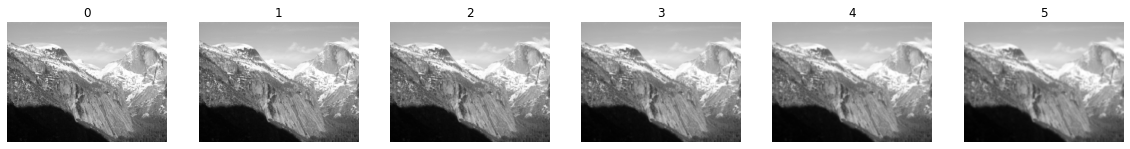

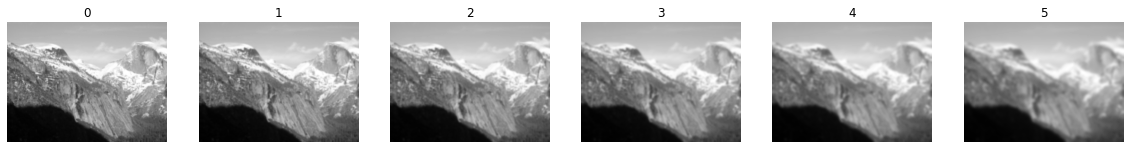

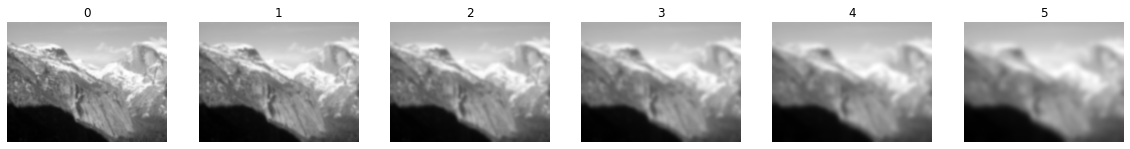

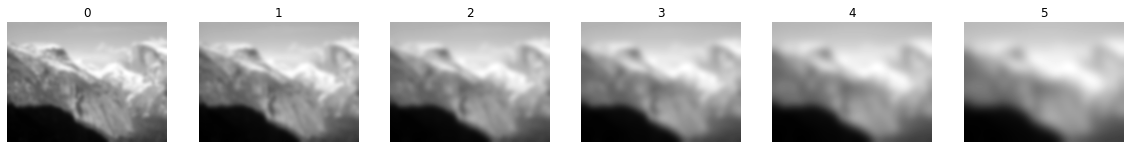

In [27]:
#Leemos la imagen de Yosemite 1
img = cv.imread("yosemite/Yosemite1.jpg",0).astype(np.float64)
#Creamos espacio de escalas
oces1 = create_octave_space(img)
#Visualizamos
print_octave_space(oces1,figsize=(20,20))

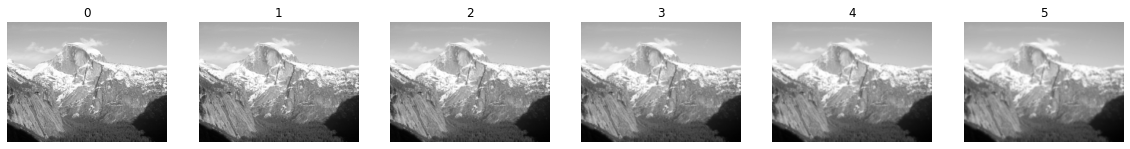

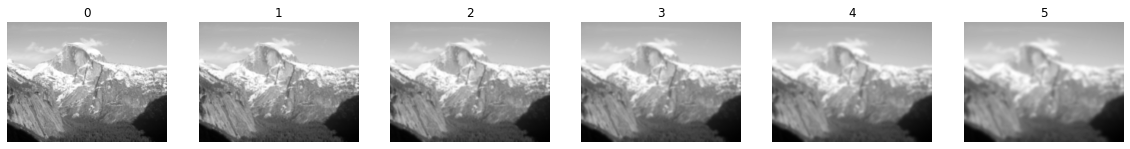

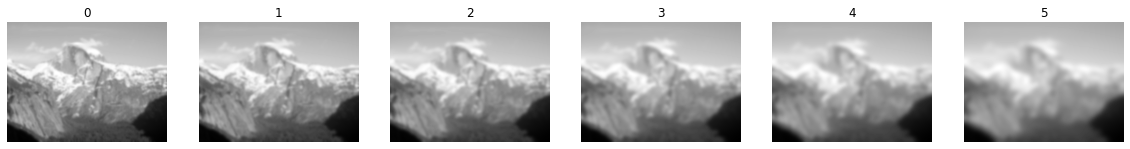

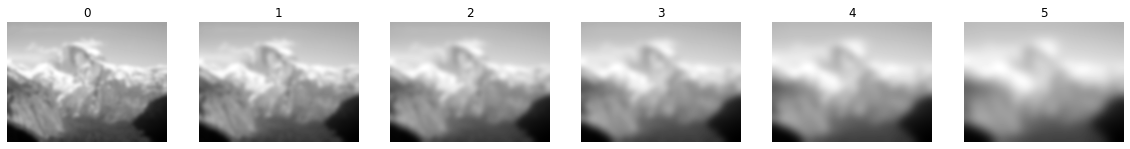

In [28]:
#Leemos la imagen de Yosemite 2
img = cv.imread("yosemite/Yosemite2.jpg",0).astype(np.float64)
#Creamos espacio de escalas
oces2 = create_octave_space(img)
#Visualizamos
print_octave_space(oces2,figsize=(20,20))

## Apartado D

Se nos pide que calculemos el espacio de escalas Laplaciano a partir de la pirámide anterior y además vamos a localizar los 100 extremos locales con mayor respuesta. Y que también extraigamos un vector (x,y,$\sigma$,...) para cada uno de ellos en los ejes de la imagen original.

Vayamos por partes, primera mente vamos a calcular el espacio de octavas laplaciano con la función __create_laplacian_octave_space__ y lo vamos a mostrar por pantalla.

In [29]:
def create_laplacian_octave_space(oces):
    """
    Calculamos el espacio de octavas laplaciano
    @Param:
        - oces: espacio de octavas gaussiano
    """
    #Parametros por defecto
    sigma_0, noct, nspoe, nspo, sigmas = set_default_parameters()
    #Calculamos las diferencias de gaussianas
    dog = np.empty((noct,nspo-1),dtype=np.object)
    for i, octave in enumerate(oces):
        for j,img in enumerate(octave):
            if j != nspo-1:
                dog[i][j] = ( img - oces[i][j+1] )
    
    return dog
            

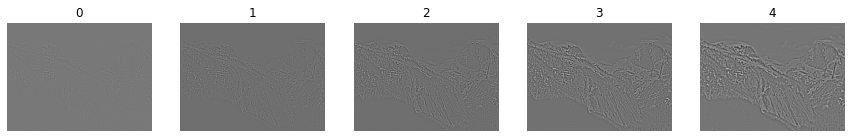

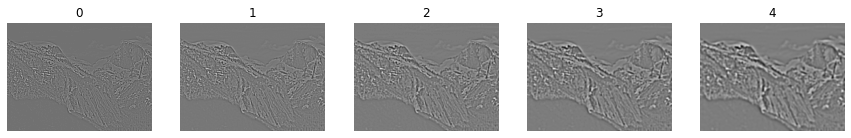

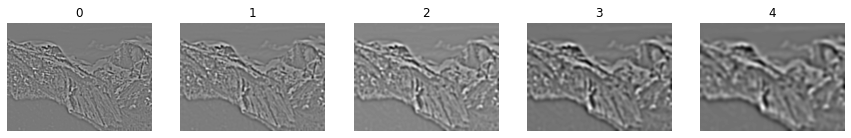

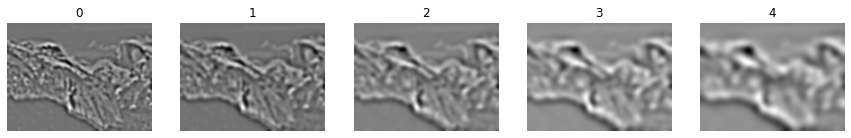

In [30]:
#Calculamos el espacio de octavas laplaciano de Yosemite 1
dog1 = create_laplacian_octave_space(oces1)
#Visualizamos
print_octave_space(dog1)

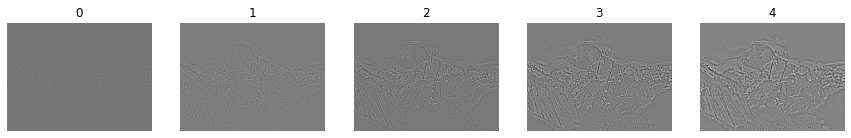

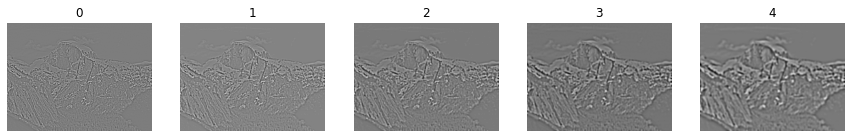

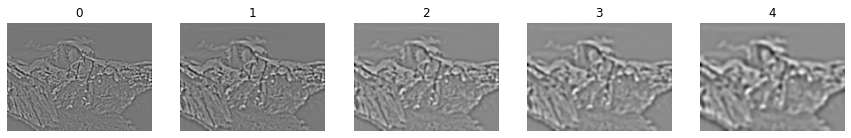

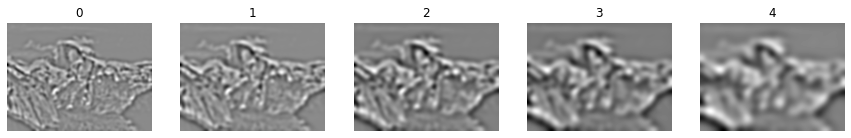

In [31]:
#Calculamos el espacio de octavas laplaciano de Yosemite 2
dog2 = create_laplacian_octave_space(oces2)
#Visualizamos
print_octave_space(dog2)

A continuación vamos a extraer todos extremos con la función __get_extremos_dog__. Para detectar los extremos tomamos un cubo 3x3x3 formado por un vecindario del pixel en cuestión tanto en la escala a la que pertecezca como en esa misma escala pero una octava por encima y otra por debajo. Nos quedamos con dicho pixel si es máximo o mínimo estricto de su vecindario. Se repite el proceso para todos los pixeles de todas la escalas de todas las octavas.

Tras ello, nos quedamos con los 100 mejores extremos usando la función __get_best_extremos__.

Después, como en cada octava, la dimensión de las imágenes no son iguales, de hecho se diferencian en una potencia de dos, se va a dar el caso de que si encontramos un extremos, la posición de sus píxeles no estén en el la misma base de coordenadas que la imagen original. Para ello hacemos una trasnformacion de la posición de un píxel en función de la octava en la que se encuentre con el método __get_coordenates_original_scale__. Aplicamos la transformación anterior a todos los pixeles del vector con la función __transform__.  


In [32]:
def get_extremos_dog(img,dog,sigmas):
    """
    Función que calcula todos los extremos del espacio de octavas laplaciano.
    @param:
    - img: imagen de la que queremos calcular los extremos
    - dog: espacio de octavas laplaciano de la imagen
    - sigmas: vector con los sigmas_s
    @return
    - Matriz (nx5)-dimensional.
        - Las columnas expresan [valor_pixel, px_x,px_y,sigma,octava]
        - Las filas son los distintos extremos
    """
    #Ahora buscamos los puntos críticos en la pirámide laplaciana
    extremos = []                                #extremos = [valor_pixel , px_x , px_y , sigma , octava]
    for o, oc in enumerate(dog):                 #Para cada octava
        for s,img in enumerate(oc):              #Para cada escala de la octava
            if s!= 0 and s!=len(oc)-1:           #Omitiendo la primera y la última
                down = oc[s-1]                   #Tomamos las escalas de arriba y abajo
                up = oc[s+1]
                for i in range(1,img.shape[0]-1):      #Recorremos los pixeles de la imagen
                    for j in range(1,img.shape[1]-1):  
                        vecin1 = down[i-1:i+2,j-1:j+2]         #Construimos vecindario de pixeles
                        vecin2 = img[i-1:i+2,j-1:j+2]
                        vecin3 = up[i-1:i+2,j-1:j+2]
                        union = np.concatenate((np.ravel(vecin1),np.ravel(vecin2),np.ravel(vecin3)),axis=0)
                        if max(union) == img[i,j] and  (union == img[i,j]).sum() == 1:                        #Si el pixel es un máximo estricto de su entorno
                            extremos.append((np.abs(img[i,j]),i,j,sigmas[s],o))                               #Lo añadimos a la lista de extremos
                        if min(union) == img[i,j] and  (union == img[i,j]).sum() == 1:                        #Si el pixel es un mínimo estricto de su entorno
                            extremos.append((np.abs(img[i,j]),i,j,sigmas[s],o))                               #Lo añadimos a la lista de extremos
    return extremos
         
    
    
    
def get_coordenates_original_scale(px,py,octava):
    """
    Obtenemos las cordenadas del la posición (px,py) de un pixel de una determinada octava en términos del tamaño
    de la imagen dada en la octava 1.
    
    Es una aproximacion ya que si la imagen tiene tamaño impar y se dividió entre dos 
    nos quedamos con la parte entera, por tanto en algunas le tenemos que sumar uno y a otras no
    """
    if octava == 0:
        px_0 = int(px/2)
        py_0 = int(py/2)
    elif octava == 1:
        px_0 = px
        py_0 = py
    else:
        px_0 = px * 2**octava
        py_0 = py * 2**octava    
    return int(px_0),int(py_0)


def get_best_extremos(extremos,number):
    # Ordenamos el vector de extremos en función del valor del pixel
    ext = extremos
    ext.sort(key = lambda ext: ext[0],reverse=True)
    # Nos quedamos con los number mejores
    ext = ext[:number]
    return ext
    
def transform(extremos):
    """
    Función que devuelve un vector con todas sus componentes transformadas
    """
    aux2 = []
    for i, v in enumerate(extremos):
        px,py = get_coordenates_original_scale(v[1],v[2],v[4]) 
        aux2.append([v[0],px,py,v[3],v[4]])
    return aux2



Finalmente mostramos por pantalla para cada una de las imágenes de Yosemite un vector donde se aprecia lo que nos pedía el enunciado, las coordenadas $(x,y)$ del pixel en las coordenadas en los ejes de la imagen original y el respectivo $\sigma$. Imprimimos también información adicional como el valor absoluto del pixel y la octava en la que se encuentra.

In [33]:
sigmas   = set_default_parameters()[4]       # Calculamos vector de sigmas para pasarlo como argumento
extremos = get_extremos_dog(img,dog1,sigmas) # Calculamos los mejores extremos 
best_ext = get_best_extremos(extremos,100)   # Nos quedamos con los 100 primeros
text     = transform(best_ext)               # Transformamos las coordenadas en términos de la primera octava

#Mostramos 10 primeros puntos con el formato [valor absoluto, px,py,sigma,octava]
print('[valor absoluto,      px,   py,   sigma,           octava]' )
text[:10]

[valor absoluto,      px,   py,   sigma,           octava]


[[26.308719102386505, 200, 28, 1.5450077936447961, 0],
 [24.493203488481413, 217, 171, 1.5450077936447961, 0],
 [23.10976955311716, 246, 68, 1.5450077936447961, 0],
 [22.943735657687995, 241, 163, 1.5450077936447961, 0],
 [22.59897006553325, 219, 175, 1.5450077936447961, 0],
 [22.576195598278417, 229, 179, 1.9465878414647126, 0],
 [22.25362216403036, 231, 187, 2.4525469969308156, 0],
 [20.92184515543582, 256, 79, 1.9465878414647126, 0],
 [20.741075689833025, 234, 63, 1.9465878414647126, 0],
 [20.252212437409298, 262, 29, 1.9465878414647126, 0]]

In [34]:
sigmas    = set_default_parameters()[4]      # Calculamos vector de sigmas para pasarlo como argumento
extremos2 = get_extremos_dog(img,dog2,sigmas) # Calculamos los mejores extremos 
best_ext2 = get_best_extremos(extremos2,100)  # Nos quedamos con los 100 primeros
text2     = transform(best_ext2)              # Transformamos las coordenadas en términos de la primera octava

#Mostramos 10 primeros puntos con el formato [valor absoluto, px,py,sigma,octava]
print('[valor absoluto,     px,   py,   sigma,           octava]' )
text2[:10]

[valor absoluto,     px,   py,   sigma,           octava]


[[20.5280440327833, 243, 421, 1.5450077936447961, 0],
 [20.083713117121192, 228, 581, 1.5450077936447961, 0],
 [20.0701496155111, 241, 128, 1.5450077936447961, 0],
 [19.910817241737163, 312, 307, 1.5450077936447961, 0],
 [19.900014475907994, 240, 545, 1.5450077936447961, 0],
 [18.54231070876807, 243, 533, 1.5450077936447961, 0],
 [18.348158051522063, 336, 296, 1.5450077936447961, 0],
 [18.23176264166017, 239, 462, 1.5450077936447961, 0],
 [17.69043931922141, 358, 335, 1.9465878414647126, 0],
 [17.623769504659407, 242, 157, 1.5450077936447961, 0]]

## Apartado E:
Vamos a mostrar la imagen con los extremos locales extraídos en el apartado anterior usando un círculo de radio $6\sigma$. Para ello vamos a definir una función __dibujar_kpts__ que dada una imagen y el vector de extremos, lo transformamos a objetos de la clase _DMatch_ usando la función __cv.KeyPoint__. Notamos que el tamaño del círculo en esa función se indica con el diámetro, por tanto tenemos que multiplicar el radio por el doble. Una vez hecho esto, calculamos una nueva imagen donde se aprecia los keypoints junto con su entornor circular gracias a la función __cv.drawKeypoints__. El flag __cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS__ viene a indicar que los Keypoints se muestren en distintos colores.  

Todo el proceso de calculo, desde el espacio de octavas hasta el dibujado de Keypoints se ha resumido en la función __show_keypoints__ presentada más abajo. 

In [35]:
def dibujar_kpts(img,text):
    """
    Dada una imagen y el vector de extremos, imprimimos por pantalla dicha imagen junto con sus extremos
    @Param:
        - img:  Imagen
        - text: vector de extremos
    @Precondition:
        El vector de extremos tiene que tener los pixeles transformados en los ejes de la imagen original.
    """
    # Dibujamos los keypoints
    keypoints = [cv.KeyPoint(x=v[2], y=v[1], size=2*int(6*v[3])) for v in text] 
    # Dibujo los keypoints sobre la imagen
    u_color = img
    u_color = cv.drawKeypoints(np.uint8(u_color), keypoints=keypoints,outImage=None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # Visualización
    plt.figure(figsize=(15,15))
    plt.imshow(u_color[:,:,::-1])

def show_keypoints(img,bonus='no',vdis=None):
    """
    Dada una imagen como parámetro calculamos los 100 keypoints más relevantes aplicando SIFT y los mostramos por pantalla.
    """
    oces     = create_octave_space(img)                  # Pirámide Lowe
    dog      = create_laplacian_octave_space(oces)       # Espacio octavas laplaciano
    sigmas   = set_default_parameters()[4]               # Calculamos vector de sigmas para pasarlo como argumento
    extremos = get_extremos_dog(img,dog,sigmas)          # Calculamos los mejores extremos de dog 
    if bonus == 'no':
        best_ext = get_best_extremos(extremos,100)                    # Nos quedamos con los 100 primeros
    else:
        best_ext = np.concatenate((vdis[0],vdis[1],vdis[2],vids[3]))  #Para el Bonus
    text     = transform(best_ext)                       # Transformamos las coordenadas en términos de la primera octava    
    dibujar_kpts(img,text)                               # Dibujamos

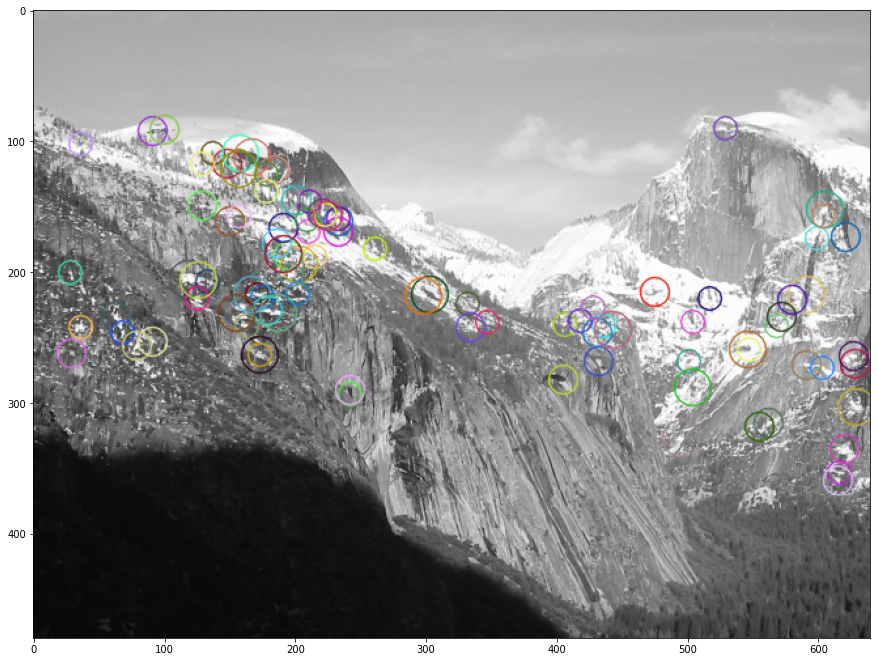

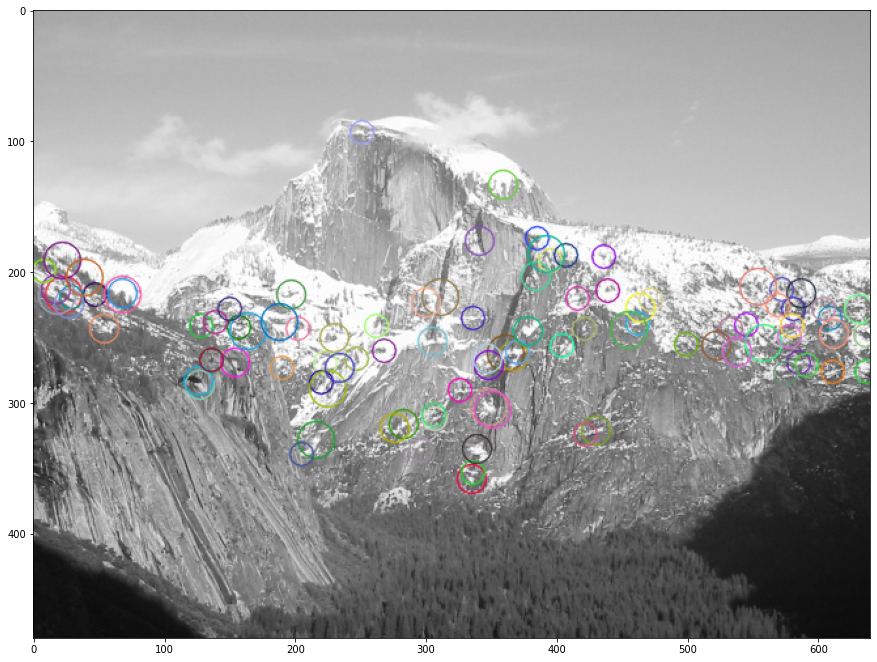

In [36]:
img1 = cv.imread("yosemite/Yosemite1.jpg",0).astype(np.float64)
img2 = cv.imread("yosemite/Yosemite2.jpg",0).astype(np.float64)
show_keypoints(img1)
show_keypoints(img2)

## Apartado F (BONUS):
Como se puede observar, a la hora del cómputo de la pirámide de Lowe, la convolución se ha realizado usando funciones propias realizadas en la práctica anterior, así como el submuestreo. Para más detalle, ver el apartado de funciones auxiliares.

## Apartado G (BONUS):
En este apartado vamos a revesitar el punto (e y d) y en vez de pintar los 100 mejores extremos de Yosemite1 vamos a pintarlos según la siguiente distribución:  
- Octava 1: 50% - 50 puntos
- Octava 2: 25% - 25 puntos
- Octava 3: 15% - 15 puntos
- Octava 4: 10% - 10 puntos

Vamos a comprobar primero que el vector con los 100 mejores extremos no cumple dicha distribución, para ello vamos a contar los elementos que hay de cada octava en la celda de abajo. Por tanto, usaremos el vector con todos los extremos y de él extraeremos un vector que sí cumpla la distribución usando la función __get_special_extremos__.

In [37]:
#Distribución del vector con los 100 mejore extremos
ptsoc = np.zeros(4,dtype=np.int)
for v in text:
    ptsoc[v[4]] = ptsoc[v[4]] + 1
print("Distribución del vector con los 100 mejore extremos:\t ", ptsoc)

#Distribicion del vector con todos los extremos
ptsoc = np.zeros(4,dtype=np.int)
for v in extremos:
    ptsoc[v[4]] = ptsoc[v[4]] + 1
print("Distribución del vector con todos los extremos:\t\t ", ptsoc)
      

Distribución del vector con los 100 mejore extremos:	  [83 15  1  1]
Distribución del vector con todos los extremos:		  [1224  775  231   57]


In [38]:
def get_special_extremos(extremos,distribution):
    """
    Función que extrae de un vector de extremos la distribución por octavas indicada en el parametro 'distribution'
    """
    # Adjustamos algunos parametros de cara al bucle 
    comienzo = 0
    fin      = 0 
    
    # Copiamos el vector de extremos para que no se modifique (opcional)
    ext = extremos.copy()
    
    # Vector en la que cada posición va a guardar los extremos correspondientes a distintas octavas, por tanto tendrá 4 subvectores
    vdis = [[],[],[],[]]
    
    # Ordenamos en orden creciente las octavas (ext[4] -- indica la octava)
    ext.sort(key = lambda ext: ext[4],reverse=False)
    
    # Calculamos la distribución de los extremos por octavas
    ptsoc = np.zeros(4,dtype=np.int)
    for v in extremos:
        ptsoc[v[4]] = ptsoc[v[4]] + 1
    
    #Calculamos mejores extremos en cada distribución
    for i,v in enumerate(distribution):
        # Dividimos el vector de extremos. Agrupamos en la posición 'i' del vector 'vdis' aquellos extremos de la octava 'i'
        if i == 0:
            fin     = ptsoc[i]
            vdis[i] = ext[:ptsoc[i]]
        else:
            comienzo = comienzo + ptsoc[i-1] 
            fin      = fin + ptsoc[i]
            vdis[i]  = ext[comienzo:fin]
        # Ordenamos de forma decreciente los extremos de la posición 'i' del vector 'vdis'
        vdis[i].sort(key = lambda v: v[0],reverse=True) 
        # Imponemos que el nuevo vector tenga la distribución deseada
        vdis[i] = vdis[i][:v]
        
    return vdis

Comprobamos que nuestro nuevo vector de extremos cumple con la distribución dada. Finalmente los mostramos por pantalla junto a la imagen. 

In [39]:
# Leemos las imágenes 
img1 = cv.imread("yosemite/Yosemite1.jpg",0).astype(np.float64)

# Indicamos la distribución que queremos
distribution = [50,25,15,10]

# Extraemos un subvector con los mejores extremos cumpliendo esa distribución. Nota: (el parámetro extremos lo hemos reciclado de apartados anteriores para no tener que volver a calcularlo)
vdis = get_special_extremos(extremos,distribution)

# Comprobamos que la distribución que tiene el subvector es, en efecto, la deseada
ptsocs = np.zeros(4,dtype=np.int)
for i,v in enumerate (vdis):
    for j,vv in enumerate (v):
        ptsocs[vv[4]] = ptsocs[vv[4]] + 1
print("Vector con todos los extremos:\t\t ", ptsocs)


Vector con todos los extremos:		  [50 25 15 10]


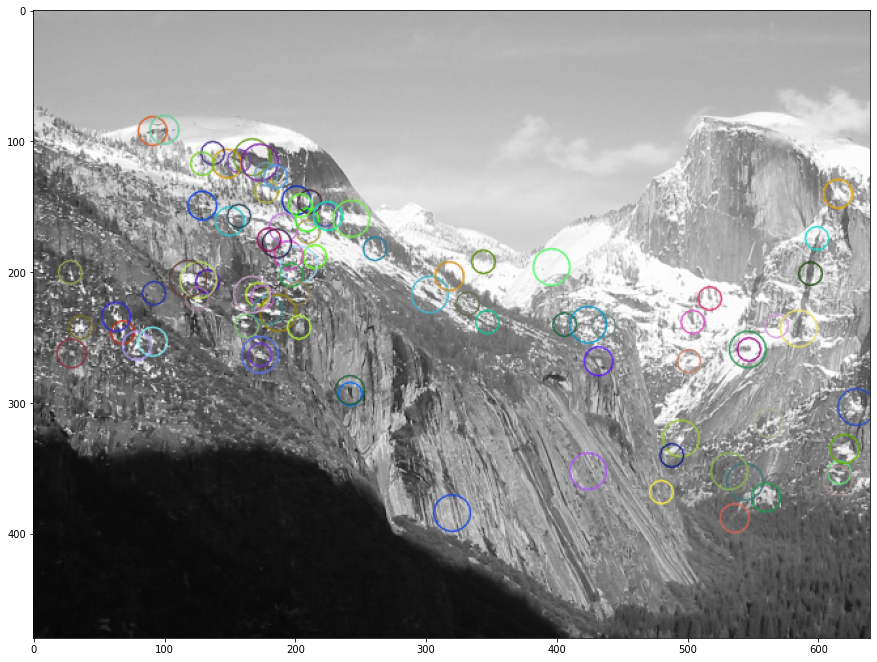

In [40]:
#Concatenemos el vector para que tenga dimensión 1xn
vector = np.concatenate((vdis[0],vdis[1],vdis[2],vdis[3]))

#Transformamos las coordenadas al sistema de ejes de la imagen original
vector = transform(vector)

#Visualizamos
dibujar_kpts(img1,vector)

# Ejercicio 2

En este ejercicios vamos a considerar las dos imágenes de Yosemite que nos proporciona el profesorado. Son dos imágenes de un mismo paisaje realizadas con un ligero desplazamiento de la cámara, esto debe de ser así para que el ejercicio tenga interés ya que no tendría sentido si fueran dos imágenes totalmente distintas. 

Se va a emplear el método SIFT de OpenCV y vamos a detectar los puntos de interés de cada imagen, a extraer los descriptores y a establecer las correspondencias. Para ello usamos la función __compute_matches__ descrita más abajo, donde el parámetro _criterio_ viene a indicar si usamos el criterio de _BruteForce+crossCheck_ o _Lowe-Average-2NN_. Ambos son criterios para refinar la obtención de correspondencias. 

Como detalle de implementación, se ha optado por construir un objeto SIFT por defecto, ya que el número de octavas y escalas lo calcula de forma personalizada para la imagen que le pasamos, de este modo podemos suponer que el cálculo lo hace de la mejor manera posible de cara a obtener buenos resultados. 

In [41]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

#Leemos las imagenes
img1 = cv.imread('yosemite/Yosemite1.jpg',0)
img2 = cv.imread('yosemite/Yosemite2.jpg',0)

def compute_matches(img1,img2,criterio='BF'):
    """
    Función que dadas dos imágenes 'img1' , 'img2' y la elección de un criterio. Calculamos las correspondoncencia entre ellas
    @return
        Vector de la forma [keypoints_img1, descriptor_img1, keypoints_img2, descriptor_img2, matches] donde todas las componentes son también vectores
    """
    
    #Creamos una instancia de la clase SIFT por defecto
    sift = cv.SIFT_create()
    
    #Detectamos keypoints y descriptores de ambas imágenes
    kpts1, desc1 = sift.detectAndCompute(img1,None)
    kpts2, desc2 = sift.detectAndCompute(img2,None)
    
    matches = [] 
    
    if criterio=='BF':
        #Creamos el objeto BF matcher con la norma L2 y crossCheck True para que haga doble correspondencia
        bf = cv.BFMatcher(normType=cv.NORM_L2, crossCheck=True)
        #Hacemos match en los desciptores
        matches = bf.match(desc1,desc2)
        
    else:
        #Creamos el objeto match y calculamos los matches usando KNN k = 2
        bf2 = cv.BFMatcher()#DUDA PABLOOO
        matches_arr = bf2.knnMatch(desc1,desc2,k=2)

        # ratio test
        matchesMask = [[0,0] for i in range(len(matches_arr))]
        for i,(m,n) in enumerate(matches_arr):
            if m.distance < 0.7*n.distance:
                matchesMask[i]=[1,0]
                matches.append(m)
                
    return kpts1,desc1,kpts2,desc2,matches
                
    
def show_random_pts(img1,img2,kpts1,kpts2,matches,number=100,figsize=(20,20)):
    """
    Funcion que dibuna los matches en las imagenes y los muestra por pantalla
    """
    
    #Vector de indices con number posiciones aleatorias del vector matches
    elements = np.random.choice(len(matches),number)
    

    #Imagen con los keypoints pintados
    img_ret = cv.drawMatches(img1,kpts1,img2,kpts2,np.asarray(matches,dtype=object)[elements],None,matchColor=None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    #Mostramos la imagen por pantalla
    show_image(img_ret,figsize=figsize)

Mostramos a continuación las correspondencias pintadas, primero para el criterio de BF y luego para el criterio de Lowe-2NN


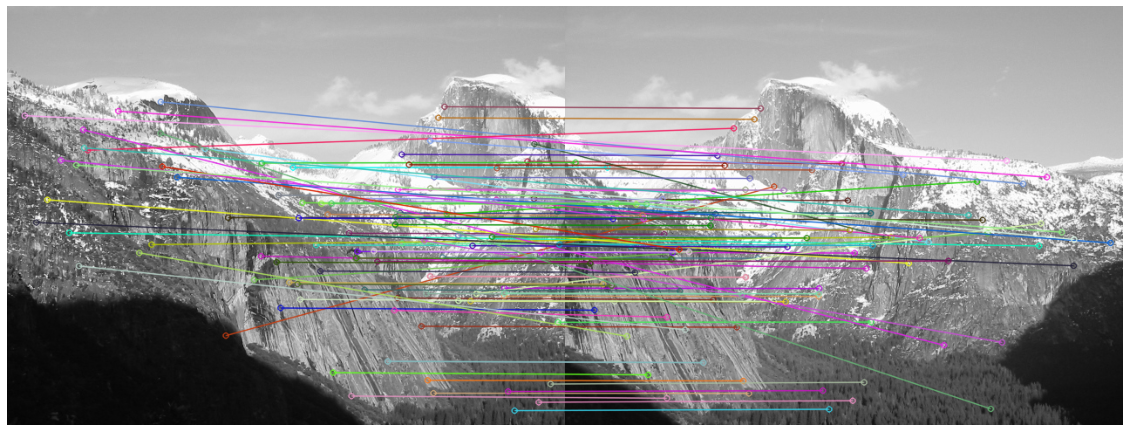

In [42]:
#BruteForce + CrosCheck
kpts1,desc1,kpts2,desc2,matches = compute_matches(img1,img2,criterio='BF')
show_random_pts(img1,img2,kpts1,kpts2,matches)

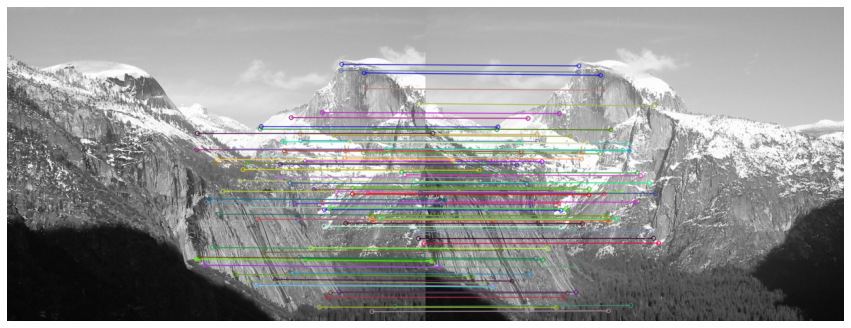

In [43]:
#Lowe-2-NN
kpts1,desc1,kpts2,desc2,matches = compute_matches(img1,img2,criterio='Lowe')
elements = np.random.choice(len(matches),100)
img_ret = cv.drawMatches(img1,kpts1,img2,kpts2,np.asarray(matches,dtype=object)[elements],None,matchColor=None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show_image(img_ret,figsize=(15,15))

A modo de conclusión podemos decir que el método de Lowe-2NN tienes unos resultados más verosímiles que el otro criterio. Esto se puede ver de forma visual debido a que el criterio de Lowe tiene las correspondencias en líneas paralelas mientras que el otro criterio no. Como las imágenes se han tomado con una traslación en el eje X, los puntos de interés quedan desplazados de una imagen con respecto a otra solo en el eje X y tiene sentido que las correspondencias definan líneas paralelas entre sí. 

# Ejercicio 3

En este ejercicio vamos a realizar un proceso similar al ejercicio anterior pero con la diferencia que aquí vamos a coser las imágenes, es decir, vamos a construir un mosaico.

In [44]:
##Cargamos las imágenes con las que vamos a trabajar, las imágnes presentan un solapamiento 2-a-2
imgm1 = cv.imread('./Mosaico_Alhambra/alhambra1.jpg',1)
imgm2 = cv.imread('./Mosaico_Alhambra/alhambra2.jpg',1)
imgm3 = cv.imread('./Mosaico_Alhambra/alhambra3.jpg',1)

## Apartado A:

Se nos pide extraer los KeyPoints SIFT y establecer un conjunto de correspondencias entre cada dos imágenes solapadas. Para ello vamos a reciclar la función del ejercicio 2, __compute_matches__ y vamos a comprar los dos criterior, 'BF' y 'Lowe-2NN' para decidir cual escoger. Mostraremos los match usando la función __show_random_pts__ también descrita en el ejercicio 2.

In [45]:
print("Criterio BF+CC")
#Calculamos los keypoints, descriptores y matches de las parejas de imágenes
kpts1 ,desc1 ,kpts2,desc2,matches_12 = compute_matches(imgm1,imgm2,criterio='BF')
trasb1,trash2,kpts3,desc3,matches_23 = compute_matches(imgm2,imgm3,criterio='BF')

#Mostramos los match 
show_random_pts(imgm1,imgm2,kpts1,kpts2,matches_12)
show_random_pts(imgm2,imgm3,kpts2,kpts3,matches_23)

Output hidden; open in https://colab.research.google.com to view.

Observamos visualmente el gran número de outlies presentes, por lo que intuitivamente llegamos a la conclusión que usando este criterio no obtendremos buenos resultados. 

In [46]:
print("Criterio Lowe-2NN")
#Calculamos los keypoints, descriptores y matches de las parejas de imágenes
kpts1 ,desc1 ,kpts2,desc2,matches_12 = compute_matches(imgm1,imgm2,criterio='Lowe')
trasb1,trash2,kpts3,desc3,matches_23 = compute_matches(imgm2,imgm3,criterio='Lowe')

#Mostramos los match 
show_random_pts(imgm1,imgm2,kpts1,kpts2,matches_12)
show_random_pts(imgm2,imgm3,kpts2,kpts3,matches_23)

Output hidden; open in https://colab.research.google.com to view.

Visualmente podemos darnos cuenta de que este criterio (Lowe) de cara a la construcción del mosaico va a ofrecer mejores resultados que el otro. Por tanto, tomaremos éste último para la realización del ejercicio. 

## Apartado B:
Vamos ahora a estimar la homografía entre las imágenes a partir de dichas correspondencias. Para ello emplearemos la función de OpenCV __cv.findHomography__ cuya sintaxis es la siguiente:
- __srcPoints:__ Coordenadas de los puntos de origen (plano original)
- __dstPoints:__ Coordenadas de los puntos de destino (plano objetivo)
- __method:__ Método usado para computar la matriz de la homografía, tenemos "RANSAC,LMEDS,RHO,PROSAC...
- __ransacReprojThreshold:__ Umbral a partir del cual y en términos de distancia una correspondencia es tratada como outliers 

Tal y como se nos pedía en el enunciado se ha usado __method = RANSAC__ ya que RANSAC tiene el objetivo de establecer una partición de outliers e inliers y estimar el modelo en base a éstos últimos. Es un método bastante robuesto a outliers y aunque presente algunos inconvenientes como el de tunear parámetros, repetir varias veces el modelo, etc, no van a suponer para este caso un problema. Ademá al partir del criterio de Lowe-2NN vamosa a tener un conjunto en el que los outliers van a ser ínfimos.  

Por otra parte el umbral __ransacRreprojThreshold__ se usa en la siguiente expresión
$$∥dstPoint_{s_{i}}−convertPointsHomogeneous(H∗srcPoint_{s_{i}})∥_{2}>ransacReprojThreshold$$
Si esa expresión es cierta entonces el punto se considera como ouliers. Al trabajar con píxeles, se suele usar un número comprendido entre 1 y 10, en este caso se ha optado por 5. Ya que debido problemas de refinamiento y al no hacer una interpolación, considerar un umbral demasiado bajo puede ser contraproducente, en cambio, un umbral demasiado alto puede también provocar comportamientos indeseados.  

Los __puntos de orignen y de destino__ es un parámetro clave y que hay que entender bien para la construcción del mosaico. Los puntos de origen por así decirlo van a ser los puntos que van a parar a los puntos de destino, por tanto la homografía se computa de tal manera que lleve los puntos de la imagen origen a la de destino. Si tomamos como imagen origen __img1__ y como destino __img2__ y luego hacemos otra homografía que tome como origen __img2__ y como destino __img3__ a la hora crear el mosaico tendremos problemas y las imágenes no quedarían bien pegadas. Esto se puede ver ya que si aplicamos primero la homografía que lleva la __img2__ a __img3__, y luego la que lleva __img1__ a __img2__, tebemos que __img2__ ha sufrida una transformación previa por la primera homografía, de tal manera que al aplicarle esta nueva homografía el resultado no es el esperado. Para paliar esto, lo que se hace es tomar la imagen dos como destino siempre, y las imágenes laterales como origen. En caso de tener más imágenes, se realizan composiciones de homografías.

Finalmente, también comentamos que la homografía __H1__ descrita en la celda de abajo es una mera traslación cuya finalidad es trasladar la imagen central, en este caso la segunda, al centro del canvas. Por ese motivo no ha hecho falta computarla con _findHomography_

In [47]:
# Tomamos un array de dos posiciones con los vectores de los keypoints de cada correspondencia
match_12_kpts = [
                       [kpts1[m.queryIdx].pt for m in matches_12],  #Keypoints de la imagen 1 (origen)
                       [kpts2[m.trainIdx].pt for m in matches_12]   #Keypoints de la imagen 2 (destino)
]

match_23_kpts = [
                       [kpts2[m.queryIdx].pt for m in matches_23],  #Keypoints de la imagen 2 (destino)
                       [kpts3[m.trainIdx].pt for m in matches_23]   #Keypoints de la imagen 3 (origen)
]


# Adjutamos tamaño máximo del canvasy lo creamos
canvas_shape = (max((imgm1.shape[0],imgm2.shape[0],imgm3.shape[0]))*3, max(imgm1.shape[1],imgm2.shape[1],imgm3.shape[1])*3)

# Calculamos la traslación de la imagen central al centro del canvas
traslacion = [(canvas_shape[0]-imgm2.shape[0])/2,(canvas_shape[1]-imgm2.shape[1])/2]
H1 = np.array([[1,0,traslacion[0]], [0,1,traslacion[1]], [0,0,1]], dtype=np.float32)

# Calculamos homografías
H_left,_  = cv.findHomography(np.asarray(match_12_kpts[0]), np.asarray(match_12_kpts[1]), cv.RANSAC, 5.0)
H_right,_ = cv.findHomography(np.asarray(match_23_kpts[1]), np.asarray(match_23_kpts[0]), cv.RANSAC, 5.0)

## Apartado C:
Vamos a proceder a la construcción del mosaico. Para ello definimos primero un canvas, que es una superficie plana sobre la que proyectaremos el mosaico. Tenemos que tener en cuenta que el canvas debe de ser de una dimensión mayor a la del mosaico y debido a ello hemos tomado el ancho (alto respec.) como el triple del máximo de los anchos (altos respec.) de las imágenes.

La función clave que hemos usado ha sido __cv.warpPerspective__ cuyas parámetros son: 
- __src__ - imagen de entrada
- __dst__ - imagen de salida con el mismo tamaño y tipo que la de entrada
- __M__   - Matriz 3x3 de transformación
- __dsize__ - tamaño de la imagen de salida
- __flags__ - convinación de métodos de interpolación (#INTER_LINEAR or #INTER_NEAREST) 
- __borderMode__ - método de extrapolación del píxel (#BORDER_CONSTANT or #BORDER_REPLICATE).
- __borderValue__ - valor usado en el caso de un borde constante

Se ha optado por el flag __cv.BODER_TRANSPARENT__ de cara a la conservación de cada resultado parcial al obtener el siguiente, así evitamos que se sobreescriba creando uno nuevo, de este modo evitamos que se elimine el resutlado de la anterior ejecución. Se ha usado el flag de __cv.INTER_LINEAR__ para una mayor exactitud aplicando interpolación. 

Las imágenes son llevadas de forma secuencial al canvas. La homografía pasada a la función __warpPerspective__ será una composición de la traslación con todas la homografías de todas las imágenes empezando por el centro hasta la homografía de la imagen en cuestión. De este modo las matrices de las transformaciones usadas son para la imagen central la propia traslación definida anteriormente, para la imagen de la derecha, usamos la traslación compuesta con la homografía respectivamente calcuada y análogo para la imagen de la izquierda y de esta forma conseguimos que las tres imágenes queden en el canvas.

En cuanto al orden, de colocación de las imágenes en el canvas se ha optado por colocar las de los laterales primero y a continuación colocar la imagen central para así evitar deformaciones. Aunque con tan solo tres imágenes, va a ser poco apreciable.

In [48]:
canvas = np.zeros((canvas_shape[0],canvas_shape[1],3), dtype='uint8')

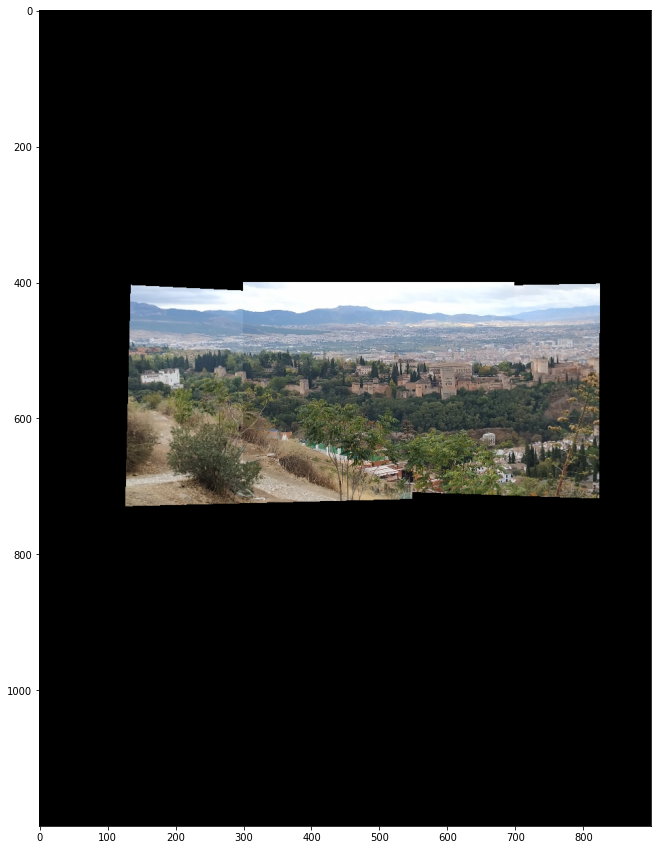

In [49]:
# Adjutamos tamaño máximo del canvasy lo creamos
canvas_shape = (max((imgm1.shape[0],imgm2.shape[0],imgm3.shape[0]))*3,
                max(imgm1.shape[1],imgm2.shape[1],imgm3.shape[1])*3)
canvas = np.zeros((canvas_shape[0],canvas_shape[1],3), dtype='uint8')

#Aplicamos wapPerspective para proyectas al canvas
canvas = cv.warpPerspective(imgm1,M = H1@H_left , dsize = (canvas_shape), dst = canvas, flags = cv.INTER_LINEAR , borderMode = cv.BORDER_TRANSPARENT)
canvas = cv.warpPerspective(imgm3,M = H1@H_right, dsize = (canvas_shape), dst = canvas, flags = cv.INTER_LINEAR , borderMode = cv.BORDER_TRANSPARENT)
canvas = cv.warpPerspective(imgm2,M = H1        , dsize = (canvas_shape), dst = canvas, flags = cv.INTER_LINEAR , borderMode = cv.BORDER_TRANSPARENT)

#Imrpimimos Mosaico
plt.figure(figsize=(15,15))
plt.imshow(canvas[:,:,::-1])

## Bonus 2 Opción(A):
Vamos a crear a continuación un panorama con proyección plana con todas las imágenes del fichero de fotos de la Alhambra. 

In [50]:
# Cargamos las imágenes con las que vamos a trabajar
im1  = cv.imread('./Mosaico_Alhambra/alhambra1.jpg',1)
im2  = cv.imread('./Mosaico_Alhambra/alhambra2.jpg',1)
im3  = cv.imread('./Mosaico_Alhambra/alhambra3.jpg',1)
im4  = cv.imread('./Mosaico_Alhambra/alhambra4.jpg',1)
im5  = cv.imread('./Mosaico_Alhambra/alhambra5.jpg',1)
im6  = cv.imread('./Mosaico_Alhambra/alhambra6.jpg',1)
im7  = cv.imread('./Mosaico_Alhambra/alhambra7.jpg',1)
im8  = cv.imread('./Mosaico_Alhambra/alhambra8.jpg',1)
im9  = cv.imread('./Mosaico_Alhambra/alhambra9.jpg',1)
im10 = cv.imread('./Mosaico_Alhambra/alhambra10.jpg',1)
im11 = cv.imread('./Mosaico_Alhambra/alhambra11.jpg',1)
im12 = cv.imread('./Mosaico_Alhambra/alhambra12.jpg',1)
im13 = cv.imread('./Mosaico_Alhambra/alhambra13.jpg',1)
im14 = cv.imread('./Mosaico_Alhambra/alhambra14.jpg',1)

# Vector con las imágenes
vim = [im1,im2,im3,im4,im5,im6,im7,im8,im9,im10,im11,im12,im13,im14]

Para la construcción del mosaico se han computado todos los keypoints y descriptores de cada una de las imágenes y los respectivos matches entre dos parejas consecutivas usando la función del ejercicio 2 __compute_matches__. Tras ello debemos de calcular las distintas homografías. La primera es una mera traslación de la imagen al centro de canvas. El resto de las homografías se calculan teniendo especial cuidado con los puntos de origen y destino. Este proceso queda reflejado en la función __get_homographies__. Una vez calculadas las homografías procedemos a pegar las imágenes en el canvas. Como se ha comentado anteriormente, el pegado se hará de forma secuencial, se pegarán primero las imágenes de la izquierda hasta el centro sin contarlo y después las imágenes de la derecha hasta el centro incluido.

Para que el pegado sea correcto necesitamos realizar composiciones de homografías como se comento anteriormente, en el caso de una imágen dada a la izquierda del centro, se deberá componer la traslación con todas las homografías de las imágenes empezando por la siguiente del centro hasta la actual. Por ejemplo, si queremos pegar la imagen que está tres veces a la izquierda del centro, llamemosla __D__, hasta la imagen central, llamemosla __A__ y denotando como __B__, __C__ las imágenes que están en una y dos posiciones la izquierda del centro respectivamente , necesitamos realizar la composición (H0)(Ha)(Hb)(Hc) siendo H0 la traslación, Ha la homografía que lleva la imagen B a A, Ha la homografía que lleva C a B y finalmente Hc que es la homografía que lleva D a C. Análogo para las imágenes a la derecha del centro

In [51]:
def get_matches(vim):
    """
    Se supone que las imagenes están en orden y solapadas dos a dos,
    Esta función nos devuelve un vector de keypoints ordenados, así como los descriptores y los matches
    """
    
    # Declaramos variables 
    kpts = []
    matches = []
    
    # Calculamos los keypoints así como los descriptores y los matches usando el criterio de Lowe
    for i,v in enumerate(vim):
        if i != (len(vim)-1): #Computo todos menos los dos últimos
            kp_i, dc_i, kp_ni, dc_ni, match = compute_matches(v, vim[i+1], criterio = 'Lowe' )
            kpts.append(kp_i)
            matches.append(match)
        elif i == (len(vim)-1): #Computo los dos últimos
            kp_i, dc_i, kp_ni, dc_ni, match = compute_matches(vim[i-1], v, criterio = 'Lowe' )
            kpts.append(kp_ni)
            matches.append(match)
                           
    return kpts,matches

def get_homographies(vim, vmatch, id_central,canvas_shape):
    """
    Función que dado un vector de imágenes, la posicion de la imagen central, el tamaño del canvas
    y un vector de matchs, construye las homografías necesarias para la composicion del mosaico a posteriori.
    """
    H = []
    
    # Calculamo homografía central
    traslacion = [(canvas_shape[1]-vim[id_central].shape[1])/2,(canvas_shape[0]-vim[id_central].shape[0])/2,1]
    H0 = np.asarray([[1,0,traslacion[0]],[0,1,traslacion[1]],[0,0,traslacion[2]]],dtype=np.float32)
    
    # La añadimos al vector de homografías
    H.append(H0)
    
    # Calculamos el resto de homografías
    for k, kp in enumerate(vmatch):
        # Se decide quienes son los puntos origenes y destino  en base a la posición central
        i,j = (0,1) if k < id_central else (1,0)            
        #Computamos la homografía y añadimos al vector de homografías
        Hi,_= cv.findHomography( np.array(kp[i]), np.array(kp[j]),cv.RANSAC, 5.0 )
        H.append(Hi)
        
    return H

def compute_homographies(vim, vH, idCentro ,canvaShape):
    """
    Función que dado un vector de imágenes, un vector con las respecctivas homografías, la posición 
    de la imagen central y el ccentro del canvas construye el mosaico
    """
    # Creamos el canvas
    canvas = np.zeros((canvaShape[0],canvaShape[1],3),dtype='uint8')
    
    # Vector con las correspondientes composiciones
    comp = [vH[0]]
    
    #Aplicamos homografías a las imágenes de la izquierda a la central y las proyectamos en el canvas
    for i in reversed(range(1,idCentro+1)):
        comp.insert(0,comp[0]@vH[i])
    for i in range(len(comp)):
        canvas = cv.warpPerspective(np.copy(vim[i]), M = comp[i], dsize = canvas_shape[::-1], dst = canvas, borderMode=cv.BORDER_TRANSPARENT, borderValue=0)
    
    #Aplicamos homografías a las imágenes desde la central + 1 a la última de la derecha
    comp = [vH[0]]
    for i in range(idCentro+1,len(vim)):
        comp.insert(0,comp[0]@vH[i])
    #El pegado se realiza de deracha hasta la central
    for i in range(len(comp)):
        canvas = cv.warpPerspective(np.copy(vim[len(vim)-i-1]), M = comp[i], dsize = canvas_shape[::-1], dst = canvas, borderMode=cv.BORDER_TRANSPARENT, borderValue=0)
    
    return canvas

In [52]:
def compute_mosaic(vim,canvas_shape,idCentro):
    """
    Función que dada el vector de imágenes, el tamaño del canvas y el identificador de la imagen central construye el mosaico
    """
    # Calculamos todos los keypoints, descriptores y matches
    kpts, matches = get_matches(vim)
    # Creo un vector de vectores en el que cada componente
    # tiene una tupla asocidada a un determinado match
    # en la primera posicion tenemos los puntos de origen y en la segunda los de destino
    set_kp_match = [
                     [
                      [kpts[i][p.queryIdx].pt for p in matches[i] ], 
                      [kpts[i+1][p.trainIdx].pt for p in matches[i]]
                     ]
                     for i in range(len(matches)-1)
                   ]
    
    H = get_homographies(vim,set_kp_match,idCentro,canvas_shape)
    mosaico = compute_homographies(vim,H,idCentro,canvas_shape)
    return mosaico

A continuación vamos a proceder a la construcción del mosaico, para ello primeramente seleccionamos un tamaño de canvas. Dicho tamaño lo elegimos de acuerdo a una serie de experimentos que no vamos a mencionar aplicando el conocido método de la _cuenta de la vieja_. Tras ello seleccionamos una imagen central, hay que tener en cuenta que para que quede bien el mosaicoo evitando deformaciones debemos considerara cúan fuerte ha sido la traslación en cada una de las parejas de imágenes. Una traslación poco pronunciada hará que dos imágenes se pegen con una mayor superficie de intersección que una pareja de imágenes cuya traslación sea menos pronunciada. Hemos observado que en las parejas de las imágenes de las la derecha se produce una poca traslación en la cámara mientras que en las de la izquierda sí que se produce una mayor traslación. Por ese motivo se ha elegido como imagen central la imagen 4 para evitar una deformación excesiva en las imagenes de la izquierda. 

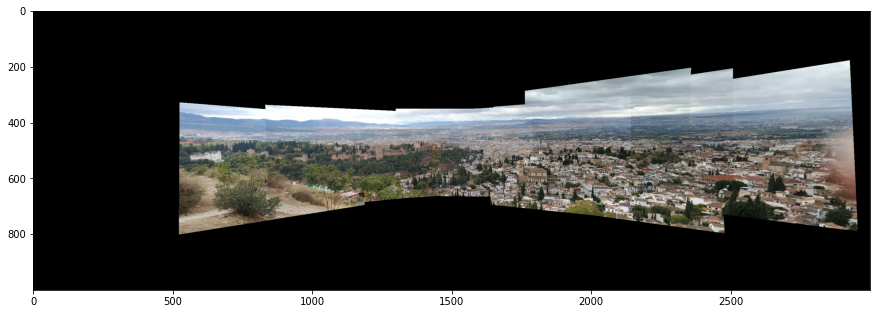

In [59]:
# Seleccionamos un tamaño del canvas 
canvas_shape = (1000,3000)  
# Indicamos la imagen central
idCentro = 4
# Construimos el mosaico
mosaico = compute_mosaic(vim,canvas_shape,idCentro)
# Visualizamos
plt.figure(figsize=(15,15))
plt.imshow(mosaico[:,:,::-1])

Más abajo mostramos un ejemplo de la reconstrucción del mosaico tomando como imagen central la imagen 7 (de 14). Observamos de manera visual que hay manifiestas deformaciones sobre todo a la izquierda debido a lo anteriormente mencionado. 

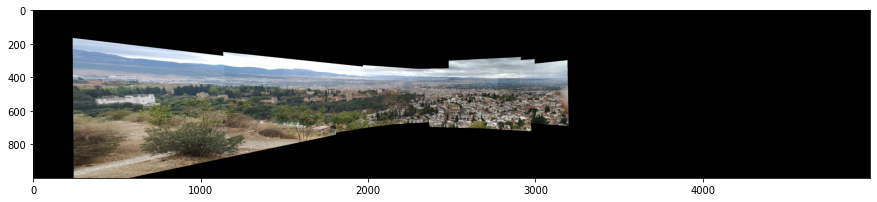

In [60]:
# Seleccionamos un tamaño del canvas 
canvas_shape = (1000,5000)  
# Indicamos la imagen central
idCentro = 7
# Construimos el mosaico
mosaico = compute_mosaic(vim,canvas_shape,idCentro)
# Visualizamos
plt.figure(figsize=(15,15))
plt.imshow(mosaico[:,:,::-1])